# SET-UP

In [ ]:
# imports

import os
from pathlib import Path

import torch
import torch.nn as nn
import torch.nn.functional
from torchvision import transforms

import matplotlib.pyplot as plt
import numpy as np

import cv2
from PIL import Image

### Download Data into Google Colab Environment

In [ ]:
# download if zip files not already downloaded
if not os.path.exists('data.zip'):
    !gdown '1KCEr8wD4vGuYhop8ShshLFPnx-3wzeSW'
else:
    print('data.zip already exists')

# unzip if folders don't already exist
if not os.path.exists('data'):
    !unzip -qq data.zip
    !rm data.zip
else:
    print('data folder already exists')

Downloading...
From (original): https://drive.google.com/uc?id=1KCEr8wD4vGuYhop8ShshLFPnx-3wzeSW
From (redirected): https://drive.google.com/uc?id=1KCEr8wD4vGuYhop8ShshLFPnx-3wzeSW&confirm=t&uuid=8864509c-e8ec-4998-b23a-10626216f3bb
To: /content/data.zip
100% 289M/289M [00:03<00:00, 91.1MB/s]


## Transforming Datasets

In [ ]:
# batch size
B = 4

In [ ]:
from torch.utils.data import DataLoader
from seq_dataset import SeqDataset

# transformations for training data
train_transform = transforms.Compose([
        transforms.RandomResizedCrop(size=256, scale=(0.8, 1.0)),
        transforms.RandomRotation(degrees=15),
        transforms.ColorJitter(brightness=0.5),
        transforms.RandomHorizontalFlip(),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

# transformations for validation data
valid_transform = transforms.Compose([
        transforms.Resize(size=256),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

# transformations for test data
test_transform = transforms.Compose([
        transforms.Resize(size=256),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

# set up dataset
dataset = SeqDataset(root_dir='data', transform=None)

In [ ]:
from torch.utils.data import random_split, DataLoader

# picking out the sizes
train_size = int(0.6 * len(dataset))              # 60% for training
val_size = int(0.1 * len(dataset))                # 10% for validation
test_size = len(dataset) - train_size - val_size  # 30 for testing

# split the dataset into train, validation, and test sets
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

# apply transformations
train_dataset.dataset.transform = train_transform  # assign training transform
val_dataset.dataset.transform = valid_transform    # assign validation transform
test_dataset.dataset.transform = test_transform    # assign test transform

# dataloaders
train_loader = DataLoader(train_dataset, batch_size=B, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=B, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=B, shuffle=False)

### Visualize Data

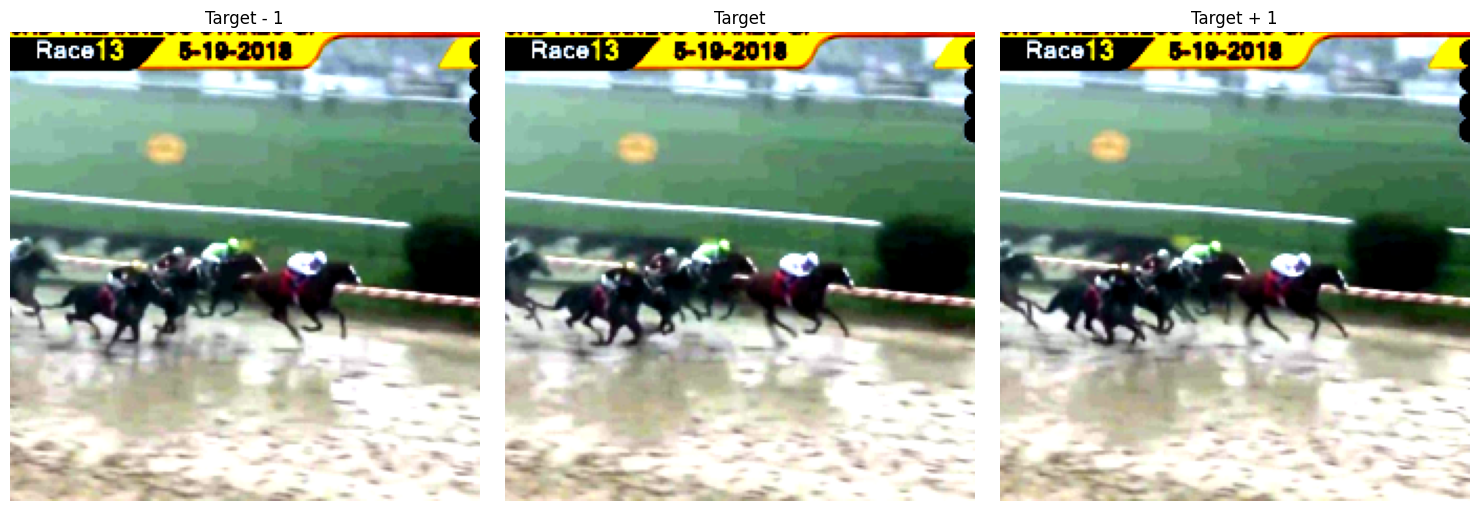

In [ ]:
import matplotlib.pyplot as plt

tgt, [s1, s2] = train_dataset[10]
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.title("Target - 1")
plt.imshow(s1.permute(1, 2, 0).numpy())
plt.axis('off')

plt.subplot(1, 3, 2)
plt.title("Target")
plt.imshow(tgt.permute(1, 2, 0).numpy())
plt.axis('off')

plt.subplot(1, 3, 3)
plt.title("Target + 1")
plt.imshow(s2.permute(1, 2, 0).numpy())
plt.axis('off')

plt.tight_layout()
plt.show()

# Training

In [ ]:
from depth_net import DepthNet
from pose_net import PoseNet
from depth_trainer import DepthTrainer

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

intrinsics = torch.eye(3).unsqueeze(0).repeat(B, 1, 1).to(device)

In [21]:
import sys
def export_model_weights(model, var_name="depth_weights"):
    print(f"# === COPY THIS INTO A FILE TO RELOAD LATER ===\n{var_name} = {{")
    for name, param in model.state_dict().items():
        data = param.cpu().numpy().tolist()
        print(f"    '{name}': {data},")
    print("}\n# === END ===")

## Version A: LR=1e-4


In [ ]:
depth_A = DepthNet().to(device)
pose_A = PoseNet().to(device)

params = list(depth_A.parameters()) + list(pose_A.parameters())
optimizer = torch.optim.Adam(params, lr=1e-4)

trainer_A = DepthTrainer(depth_A, pose_A, optimizer, intrinsics, train_loader, device, epochs=100)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 160MB/s]


In [ ]:
trainer_A.train()


EPOCH 1 -----------------------------
[average loss: 1.0273]

EPOCH 2 -----------------------------
[average loss: 0.9818]

EPOCH 3 -----------------------------
[average loss: 0.9668]

EPOCH 4 -----------------------------
[average loss: 0.8864]

EPOCH 5 -----------------------------
[average loss: 0.8950]

EPOCH 6 -----------------------------
[average loss: 0.7522]

EPOCH 7 -----------------------------
[average loss: 0.5727]

EPOCH 8 -----------------------------
[average loss: 0.4798]

EPOCH 9 -----------------------------
[average loss: 0.4470]

EPOCH 10 -----------------------------
[average loss: 0.4052]

EPOCH 11 -----------------------------
[average loss: 0.3917]

EPOCH 12 -----------------------------
[average loss: 0.3866]

EPOCH 13 -----------------------------
[average loss: 0.3784]

EPOCH 14 -----------------------------
[average loss: 0.3592]

EPOCH 15 -----------------------------
[average loss: 0.3558]

EPOCH 16 -----------------------------
[average loss: 0.3603]



In [15]:
with open('modelA_weights_output.txt', 'w') as f:
    sys.stdout = f
    export_model_weights(depth_A, var_name="depth_A_weights")
    export_model_weights(pose_A, var_name="pose_A_weights")
    sys.stdout = sys.__stdout__

## Version B: LR=1e-5

In [ ]:
depth_B = DepthNet().to(device)
pose_B = PoseNet().to(device)

params = list(depth_B.parameters()) + list(pose_B.parameters())
optimizer = torch.optim.Adam(params, lr=1e-5)

trainer_B = DepthTrainer(depth_B, pose_B, optimizer, intrinsics, train_loader, device, epochs=100)

In [ ]:
trainer_B.train()

In [ ]:
with open('modelB_weights_output.txt', 'w') as f:
    sys.stdout = f
    export_model_weights(depth_B, var_name="depth_B_weights")
    export_model_weights(pose_B, var_name="pose_B_weights")
    sys.stdout = sys.__stdout__

## Version C: LR=1e-6

In [ ]:
depth_C = DepthNet().to(device)
pose_C = PoseNet().to(device)

params = list(depth_C.parameters()) + list(pose_C.parameters())
optimizer = torch.optim.Adam(params, lr=1e-6)

trainer_C = DepthTrainer(depth_C, pose_C, optimizer, intrinsics, train_loader, device, epochs=100)

In [ ]:
trainer_C.train()

In [ ]:
with open('modelC_weights_output.txt', 'w') as f:
    sys.stdout = f
    export_model_weights(depth_C, var_name="depth_C_weights")
    export_model_weights(pose_C, var_name="pose_C_weights")
    sys.stdout = sys.__stdout__

# Evaluation

In [16]:
trainer_A.get_loss()

[1.0272639778122974,
 0.981779383456529,
 0.9668306520625727,
 0.8864223109252417,
 0.8950001395460385,
 0.7522240699227176,
 0.5726815567977392,
 0.4798451761701214,
 0.447023007851928,
 0.4052487734538406,
 0.3917478975075394,
 0.3866394518916287,
 0.37842171058725954,
 0.35918345549213354,
 0.3557658273782303,
 0.36025061660738134,
 0.35796400335297657,
 0.3573347875876213,
 0.355377035132095,
 0.3564358086283527,
 0.34663416852257145,
 0.34803300032864753,
 0.3476509590202303,
 0.34566968465918924,
 0.3309526921653036,
 0.3425260750215445,
 0.3273459849517737,
 0.35066612140456244,
 0.32747761420349575,
 0.33601476478932507,
 0.3385414375965275,
 0.3362915314622779,
 0.3253905850559918,
 0.3280223262843801,
 0.3222896518102333,
 0.33045020172400263,
 0.3453889356175465,
 0.3277629935919349,
 0.32199587181432926,
 0.32742036256327556,
 0.32657752386224803,
 0.31785053637490346,
 0.3338745861355938,
 0.3184710147220697,
 0.31906551322830257,
 0.3191243341164802,
 0.3137634773752583,


In [ ]:
trainer_B.get_loss()

In [ ]:
trainer_C.get_loss()